# Preparing data

In [ ]:
import numpy as np
from tensorflow.keras.utils import to_categorical

## Loading data

In [ ]:
train_data = np.load('/content/drive/MyDrive/ProbSpace/宗教画テーマの分類/dataset/christ-train-imgs.npz')['arr_0']
train_label = np.load('/content/drive/MyDrive/ProbSpace/宗教画テーマの分類/dataset/christ-train-labels.npz')['arr_0']
test_data = np.load('/content/drive/MyDrive/ProbSpace/宗教画テーマの分類/dataset/christ-test-imgs.npz')['arr_0']

print('train_data shape: {0}'.format(train_data.shape))
print('test_data shape: {0}'.format(test_data.shape))

train_data shape: (654, 224, 224, 3)
test_data shape: (497, 224, 224, 3)


## one hot encoding label data

In [ ]:
train_label = to_categorical(train_label)

print('train_label shape: {0}'.format(train_label.shape))

train_label shape: (654, 13)


# Preprocessing

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## splitting train data for hold-out

In [ ]:
train_data, val_data, train_label, val_label = train_test_split(train_data, train_label,
                                                                test_size=0.2,
                                                                shuffle=True,
                                                                random_state=2021)

print('train_data shape: {0}, train_label shape: {1}'.format(train_data.shape, train_label.shape))
print('val_data shape: {0}, val_label shape: {1}'.format(val_data.shape, val_label.shape))

train_data shape: (523, 224, 224, 3), train_label shape: (523, 13)
val_data shape: (131, 224, 224, 3), val_label shape: (131, 13)


## ImageDataGenerator

In [ ]:
datagen = ImageDataGenerator(featurewise_center=False, 
                             samplewise_center=False,
                             featurewise_std_normalization=False, 
                             samplewise_std_normalization=False,
                             zca_whitening=None, 
                             zca_epsilon=1e-06, 
                             rotation_range=180, 
                             width_shift_range=0.2,
                             height_shift_range=0.2, 
                             brightness_range=None, 
                             shear_range=5, 
                             zoom_range=0.3,
                             channel_shift_range=5., 
                             fill_mode='nearest', 
                             cval=0.0,
                             horizontal_flip=True, 
                             vertical_flip=False, 
                             rescale=1./255.,
                             preprocessing_function=None, 
                             data_format=None, 
                             validation_split=0.0, 
                             dtype=None)

## Creating generator

In [ ]:
train_generator = datagen.flow(train_data, train_label,
                               batch_size=4, 
                               shuffle=True, 
                               sample_weight=None, 
                               seed=2021,
                               save_to_dir=None, 
                               save_prefix='', 
                               save_format='png',
                               subset=None,)

val_generator = datagen.flow(val_data, val_label,
                             batch_size=4, 
                             shuffle=False, 
                             sample_weight=None, 
                             seed=2021,
                             save_to_dir=None, 
                             save_prefix='', 
                             save_format='png',
                             subset=None,)

test_generator = datagen.flow(test_data,
                              batch_size=4, 
                              shuffle=False, 
                              sample_weight=None, 
                              seed=None,
                              save_to_dir=None, 
                              save_prefix='', 
                              save_format='png',
                              subset=None,)

# Creating model

In [ ]:
!pip install tensorflow_addons
!pip install vit-keras
!pip install mlp-mixer-keras

     |████████████████████████████████| 1.1 MB 7.5 MB/s 
  Created wheel for mlp-mixer-keras: filename=mlp_mixer_keras-0.0.5-py3-none-any.whl size=4681 sha256=704fd6c6a0635c23969094385327880a9801c60f8540d08f8549633f204c502f
  Stored in directory: /root/.cache/pip/wheels/39/14/9a/3c57fd7aa64427da1fbf577e6d5c6003f273aa12044fdb64e7
Successfully built mlp-mixer-keras


In [ ]:
from tensorflow.keras.applications import VGG16, ResNet50, EfficientNetB0
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers.schedules import CosineDecay
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow_addons.losses import SigmoidFocalCrossEntropy
from vit_keras import vit, utils
from mlp_mixer_keras import MlpMixerModel

## creating vgg model

In [ ]:
def creating_vgg_model():

  input = Input(shape=(224, 224, 3))

  conv_base = VGG16(include_top=False, 
                    weights='imagenet', 
                    input_tensor=input)

  _ = GlobalAveragePooling2D()(conv_base.output)
  
  _ = Dense(13)(_)
  
  output = Activation('softmax')(_)

  model = Model(inputs=[input], outputs=[output])
  
  model.compile(optimizer=Adam(learning_rate=1e-5),
                loss=SigmoidFocalCrossEntropy(),
                metrics=['accuracy'])

  return model

## creating resnet model

In [ ]:
def creating_resnet_model():

  input = Input(shape=(224, 224, 3))

  conv_base = ResNet50(include_top=False, 
                       weights=None, 
                       input_tensor=input)
  
  _ = conv_base(input)

  _ = GlobalAveragePooling2D()(_)
  
  _ = Dense(13)(_)
  
  output = Activation('softmax')(_)

  model = Model(inputs=[input], outputs=[output])
  
  model.compile(optimizer=Adam(learning_rate=1e-5),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

  return model

## creating efficient model

In [ ]:
def creating_efficient_model():

  input = Input(shape=(224, 224, 3))

  conv_base = EfficientNetB0(include_top=False, 
                             weights='imagenet', 
                             input_tensor=input)
  
  _ = GlobalAveragePooling2D()(conv_base.output)
  
  _ = Dense(13)(_)
  
  output = Activation('softmax')(_)

  model = Model(inputs=[input], outputs=[output])
  
  model.compile(optimizer=Adam(learning_rate=1e-5),
                loss=SigmoidFocalCrossEntropy(),
                metrics=['accuracy'])

  return model

## creating vit model

In [ ]:
def creating_vit_model():

  model = Sequential()

  # vit_b16, vit_b32, vit_l16, vit_l32 #
  model.add(vit.vit_l16(image_size=224, 
                        activation='sigmoid',
                        pretrained=True, 
                        include_top=False, 
                        pretrained_top=False, 
                        classes=13,))
  
  model.add(Activation('softmax'))
  
  model.compile(optimizer=Adam(learning_rate=1e-5),
                loss=SigmoidFocalCrossEntropy(),
                metrics=['accuracy'])

  return model

## creating mlp mixer model

In [ ]:
def creating_mlp_mixer_model():

  model = MlpMixerModel(input_shape=(224, 224, 3),
                        num_classes=13, 
                        num_blocks=4, 
                        patch_size=8,
                        hidden_dim=32,
                        tokens_mlp_dim=64,
                        channels_mlp_dim=128,
                        use_softmax=True)

  model.compile(optimizer=Adam(learning_rate=1e-5),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

  return model

# Building model

In [ ]:
# model = creating_vgg_model()
model = creating_resnet_model()
# model = creating_efficient_model()
# model = creating_vit_model()
# model = creating_mlp_mixer_model()

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 13)                26637     
_________________________________________________________________
activation (Activation)      (None, 13)                0         
Total params: 23,614,349
Trainable params: 23,561,229
Non-trainable params: 53,120
_________________________________________________________________


# Training

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
from time import time

In [ ]:
callback_list = [ModelCheckpoint(filepath='model.h5', monitor='val_accuracy', save_best_only=True),]

start_time = time()
history = model.fit(train_generator,
                    epochs=100,
                    batch_size=4,
                    callbacks=callback_list,
                    validation_data=val_generator)
elapsed_time = time() - start_time

print('Elapsed time: {0:.3f} hrs'.format(elapsed_time / 3600))

Epoch 1/100
131/131 [==============================] - 31s 84ms/step - loss: 3.0216 - accuracy: 0.0994 - val_loss: 2.7798 - val_accuracy: 0.0992


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
131/131 [==============================] - 10s 74ms/step - loss: 2.5533 - accuracy: 0.1931 - val_loss: 2.7980 - val_accuracy: 0.0992
Epoch 3/100
131/131 [==============================] - 10s 74ms/step - loss: 2.4663 - accuracy: 0.2065 - val_loss: 2.7469 - val_accuracy: 0.1221
Epoch 4/100
131/131 [==============================] - 10s 74ms/step - loss: 2.4543 - accuracy: 0.2027 - val_loss: 2.6278 - val_accuracy: 0.1221
Epoch 5/100
131/131 [==============================] - 10s 74ms/step - loss: 2.4320 - accuracy: 0.2065 - val_loss: 2.5597 - val_accuracy: 0.1985
Epoch 6/100
131/131 [==============================] - 10s 74ms/step - loss: 2.4287 - accuracy: 0.1969 - val_loss: 2.6153 - val_accuracy: 0.1679
Epoch 7/100
131/131 [==============================] - 10s 74ms/step - loss: 2.4083 - accuracy: 0.2046 - val_loss: 2.6555 - val_accuracy: 0.1832
Epoch 8/100
131/131 [==============================] - 10s 73ms/step - loss: 2.3787 - accuracy: 0.2084 - val_loss: 2.9427 - val_ac

# Plotting history

In [ ]:
import matplotlib.pyplot as plt

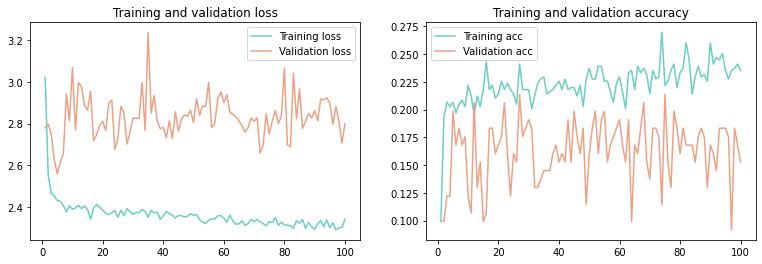

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(1, len(acc) + 1)

fig = plt.figure(figsize=(13, 4))

plt.subplot(1, 2, 1)

plt.plot(epochs, loss, 'b', color='#68CFC3', label='Training loss')
plt.plot(epochs, val_loss, 'b', color='#EDA184', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.subplot(1, 2, 2)

plt.plot(epochs, acc, 'b', color='#68CFC3', label='Training acc')
plt.plot(epochs, val_acc, 'b', color='#EDA184', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()

# Evaluating

In [ ]:
from keras.models import load_model
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

## best accuracy with val data

In [ ]:
model.load_weights('model.h5')
predicted = np.argmax(model.predict(val_generator), axis=1)

print('best validation accuracy: {0:.3f}'.format(accuracy_score(np.argmax(val_label, axis=1), predicted)))

best validation accuracy: 0.168


## Visualize confusion matrix

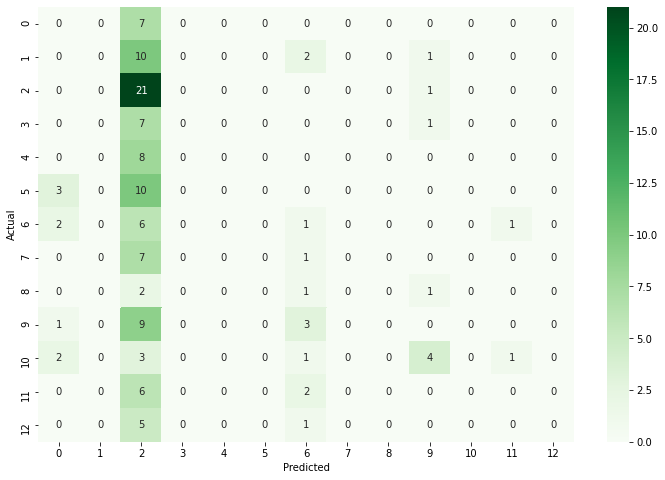

In [ ]:
cf_matrix = confusion_matrix(np.argmax(val_label, axis=1), predicted)

fig = plt.figure(figsize=(12, 8))

sns.heatmap(cf_matrix, annot=True, cmap='Greens')

plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.show()

# Submission

In [ ]:
import pandas as pd
from google.colab import files

## predicted

In [ ]:
predicted = model.predict(test_generator)

print('predicted shape: {0}'.format(predicted.shape))

predicted shape: (497, 13)


## creating csv for submission

In [ ]:
predicted = np.argmax(predicted, axis=1)

idx = np.arange(1, 498)

df = pd.concat([pd.DataFrame(idx, columns=['id']), pd.DataFrame(predicted, columns=['y'])], axis=1)

df.to_csv('submission.csv', index=False)

df.head()

,id,y
0,1,2
1,2,2
2,3,2
3,4,2
4,5,2


## downloading

In [ ]:
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# End